# BAYESIAN REGRESSION
**Abbreviations**:

- ANN: Artificial Neural Network
- BNN: Bayesian Neural Network
- HMC: Hamiltonian Monte Carlo

---

**Topics discussed**:

- [Defining a Synthetic Regression Problem](#Defining-a-Synthetic-Regression-Problem)
- [Defining the BNN - VERSION 1](#Defining-the-BNN---VERSION-1)
    - Uses the PyTorch implementation of a BNN using `torchbnn`
    - Follows variational inference as its theoretical approach
- [Defining the BNN - VERSION 2](#Defining-the-BNN---VERSION-2)
    - Uses Keras to define the neural network
    - Uses HMC for sampling model paramters
    - HMC implementation is present in `tensorflow_probability`

# Setup
## Libraries for the implementation of BNNs
The basic implementation of BNNs in Python using PyTorch can be done using [`torchbnn`](https://github.com/Harry24k/bayesian-neural-network-pytorch), which can be installed as follows:

```
!pip install torchbnn
```

The BNN implementation using HMC shall be done using Tensorflow, because we want the neural network to be compatible with the implementation of HMC we shall be using, which comes packaged with `tensorflow_probability`. In particular, we shall be using Keras to define the functional model (i.e. the neural network architecture), and HMC shall be used to obtain samples of the model's parameters. The result shall be something akin to an ensemble model.

## Necessary imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

# Defining a Synthetic Regression Problem
> **References**:
>
> - [Bayesian Neural Network Regression Demo](https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/demos/Bayesian%20Neural%20Network%20Regression.ipynb)
> - [From Theory to Practice with Bayesian Neural Network, Using Python](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825)

---

Regression will be done on this synthetic data. We generate the data using:

$y_i = f(x_i) + \epsilon_i$

- $y_i$ is the dependent variable (the "output" or "target")
- $x_i$ is the independent variable (the "input" or "feature" or "predictor")
- $\epsilon_i$ is the random noise given to the $i$-th data point

**NOTE**: _This regression problem considers only one independent variable._

The goal of regression is to estimate $f$ given the dataset $D = (x, y) = \{(x_1, y_1), (x_2, y_2) ... (x_n, y_n)\}$.

---

Specifically, we shall define:

- $f(x_i) = x_i^3 - x_i^2$
- $\epsilon_i \sim \text{Uniform}(-3, 3)$
- $n = 500$

## Training data

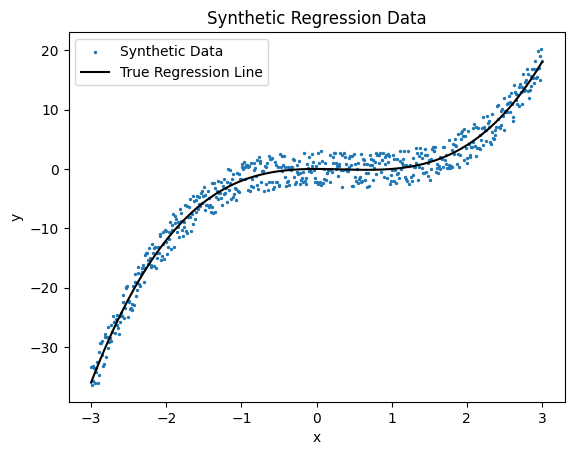

In [2]:
# SYNTHETIC DATA GENERATION

# Defining the inputs x = (x_1, x_2 ... x_500):
x_train = torch.linspace(-3, 3, 600)

# Defining f(x):
f = lambda x: x**3 - x**2

# Defining random noise ɛ = (ɛ_1, ɛ_2 ... ɛ_500):
ɛ = lambda n: 6*torch.rand(n) - 3
# NOTE 1: `torch.rand` draws from a uniform distribution on the interval [0, 1]
# NOTE 2: 6 is effectively the size of the range noise values
# NOTE 3: The above uniform distribution is on the interval [-3, 3]
# NOTE 4: I defined noise as a function so we can reuse it during testing
# NOTE 5: I defined the noise function in terms of 'n' to clarify that it is not dependent on `x`

# Adding the above to generate the final target value:
y_train = f(x_train) + ɛ(600)

#================================================
# DATA CONVERSION INTO TENSORS

# Converting each array into a 1D column tensor:
# NOTE: This is done easen passing the data through the neural network
x_train = torch.unsqueeze(x_train, dim=1)
y_train = torch.unsqueeze(y_train, dim=1)

#================================================
# DATA PRESENTATION

plt.scatter(x_train.data.numpy(), y_train.data.numpy(), s=2, label='Synthetic Data')
plt.plot(x_train.data.numpy(), f(x_train.data.numpy()), color='k', label='True Regression Line')
plt.title('Synthetic Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**NOTE**: _The true regression line is just for reference here and is obviously not accessible to the models._

## Testing data
Data used to test how well the models generalise.

In [3]:
x_test = torch.linspace(-3, 3, 500)
y_test = f(x_test) + ɛ(500)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

# Defining the BNN - VERSION 1
For our first simple BNN, we shall use Bayesian linear layers. A Bayesian linear layer is a linear layer with two key differences from a regular linear layer: (1) its weights are automatically initialised using a certain normal distribution with a certain standard deviation, and (2) its forward function is defined such that for each forward function call, the weights change probabilistically based on the aforementioned normal distribution. This normal distribution represents the variational distribution (i.e. the distribution meant to approximate the posterior): It is implemented by the class `BayesLinear` in `torch.bnn`, and the arguments of its constructor are as follows:

- `prior_mu` (float): Mean of prior normal distribution
- `prior_sigma` (float): Standard deviation of prior normal distribution
- Other arguments are following [linear of pytorch 1.2.0](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py)

In particular, for each function call, the weights $w$ are changed to $w_\mu + \text{Normal}(0, \sigma)$, where $w_\mu$ is the mean of the layer's current weights and $\sigma$ is the standard deviation of the prior normal distribution. The bias term is changed the same way. Hence, a BNNs predictions are not deterministic, like a regular neural network, but probabilistic; each prediction of the model is going to be slightly different, as though the model parameters are not fixed but drawn from the estimated posterior distribution.

_Additional points_...

- `BayesLinear` offers a `freeze` function that can freeze the weights
- Freezing the Bayesian linear layer's weights makes it behave like a regular linear layer
- Its `unfreeze` _function unfreezes the weights again

> **Reference**: [torchbnn/modules/linear.py](https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/torchbnn/modules/linear.py)

---

The loss is the weighted sum of the mean squared error (MSE) and the Kullback-Leibler divergence (KL divergence). The KL divergence is implemented by the class `BKLLoss` in `torch.bnn` ('B' stands for "Bayesian", since we are calculating the KL divergence for a Bayesian layer). Its constructor has no mandatory arguments and some optional arguments, which are as follows:

- `reduction`: Specifies the reduction to apply to the output (default = 'mean')
    - 'mean' $\implies$ The sum of the output will be divided by the number elements of the output
    - 'sum' $\implies$ the output will be summed
- `last_layer_only` (boolean): `True` means only the last layer's KL divergence is returned (default = `False`).

> **Reference**: [torchbnn/modules/loss.py](https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/torchbnn/modules/loss.py)

In [4]:
# DEFINING THE MODEL

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=1, out_features=100), # Input layer
    nn.ReLU(),                                                                   # Non-linear activation
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1)) # Output layer

#================================================
# DEFINING THE LOSS FUNCTION

# Initialising MSE part of the loss function:
mse_loss = nn.MSELoss()

# Initialising the KL divergence part of the loss function:
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01 # The weight given to the KL divergence part of the loss function

# Initialising the optimiser used for gradient descent:
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training the model
One regression step and hence one training step involves:

1. Calculating the predicted values for all the inputs
2. Calculating the total loss for all the predicted values
3. Altering the weights through backpropagation

---

Also note the following:

- $x$ is the tensor of all inputs
- $y$ is the tensor of all "actual" outputs ("actual" in quotes because our data is synthetic)
- $f$ is the target function, such that $f(x) \approx y$
- We shall perform a high number of regression steps to estimate the target function $f$

In [5]:
for step in range(3000):
    # Obtaining the model's predicted values for the inputs:
    prediction = model(x_train)

    # Calculating the loss function:
    mse = mse_loss(prediction, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl

    # Optimisation step:
    optimizer.zero_grad() # Resetting the optimiser's gradients
    cost.backward()       # Calculating the gradients for backpropagation
    optimizer.step()      # Applying the gradients for backpropagation
    
print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

MSE : 6.03, KL : 0.83


## Testing the model

Obtaining and testing the predictions...

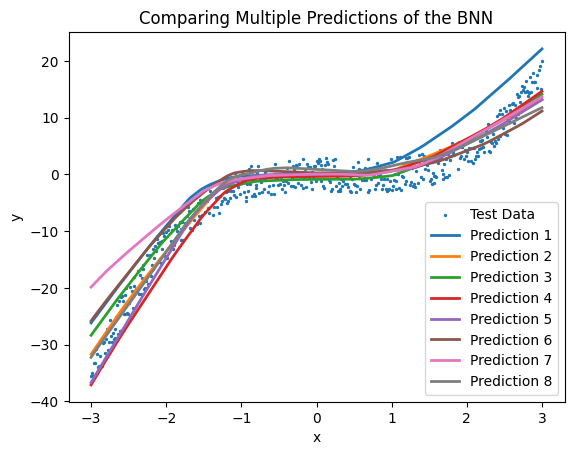

In [6]:
# Plotting the test data:
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), s=2, label='Test Data') 

# Obtaining and plotting multiple predictions:
for i in range(8):
    y_predict = model(x_test)
    plt.plot(x_test.data.numpy(), y_predict.data.numpy(), linewidth=2, label=f'Prediction {i+1}')

# Final formatting for the plot:
plt.title('Comparing Multiple Predictions of the BNN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Key points

We have seen how a BNN is a machine learning model that incorporates the power of a neural network while making the uncertainty about its parameters more explicit (by making the model's weights probabilistic). The idea is not to optimise the loss of a neural network but the loss of an unlimited class of neural networks; note that this unlimited class of neural networks is defined as the set of all neural networks whose parameters are distributed according to a particular probability distribution (initially assumed to be the prior distribution, later estimated to be the posterior distribution or at least close to it). In other words, we are optimising the probability distribution of our model parameters given a dataset. We optimise using a loss function that incorporates the metric known as Kullback-Leibler divergence (KL divergence), which is a way to quantify the distance between two distributions (in our case, we aim to quantify the estimated distance between the distribution of the model's parameters as defined by us and the actual posterior distribution of the model's parameters; we do not know the actual posterior distribution, which is why we esimate, as is explained in the next section). After optimising our loss function, we are able to use a model that is probabilistic. This means that if we repeat this model twice we get two different results, and if we repeat it many times, say, 10000 times, we can extract a robust statistical distribution of our results.

> **Reference**: [From Theory to Practice with Bayesian Neural Network, Using Python](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825)

## Conceptual observations
Note that the theoretical approach we used is such that we try to minimise the distance between the distribution of our model's parameters and the actual posterior distribution of the model's parameters, so that when we sample parameter values from our distribution, we are approximately sampling from the actual posterior distribution. This theoretical approach is called **variational inference**, where our estimated distribution is called the variational distribution. It is key to note that we obviously do not know the posterior distribution; if we did, there would be no need to estimate it. Rather, to minimise the distance between the variational and posterior distributions, we use the evidence lower bound (ELBO), which is a formula derived from the actual KL divergence between the variational and posterior distributions:

$\displaystyle \text{ELBO} = \int_{\theta \in \Theta} q_\phi(\theta) \log \frac{p(\theta, D)}{q_\phi(\theta)} d\theta$

> **Read further**: ["Variational inference" from _Sampling Methods_ from **Bayesian Inference** from `conceptual-notes`](https://github.com/pranigopu/mastersProject/blob/main/conceptual-notes/bayesian-inference/sampling-methods/variational-inference-vi)

# Defining the BNN - VERSION 2

For our second BNN, we shall use a traditional artificial neural network (ANN), but we shall sample its weights from a posterior estimated using Hamiltonian Monte Carlo (HMC). To get an idea about the application of HMC, see: [`mastersProject`/`code`
`/hamiltonian_monte_carlo.ipynb`](https://github.com/pranigopu/mastersProject/blob/main/code/hamiltonian_monte_carlo.ipynb).

## Necessary imports

In [44]:
import keras
import tensorflow_probability as tfp
import tensorflow as tf

# To handle statistical distributions:
tfd = tfp.distributions

## Neural network definition
The functional model to estimate the problem's solution...

In [18]:
def get_model(lr=0.001):
    # BUILD MODEL TOPOLOGY
    
    model = keras.Sequential([
        keras.layers.Input((1,)),                   # Input (single dimension)
        keras.layers.Identity(),                    # To see the input layer shapes in the model summary
        keras.layers.Dense(100, activation='relu'), # Hidden layer
        keras.layers.Dense(1)])                     # Output layer, with linear activation
    
    #------------------------------------
    # COMPILING MODEL WITH APPROPRIATE LOSS AND OPTIMIZER

    # Optimizer:
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    # Loss function:
    loss = keras.losses.MeanSquaredError()
    # Compiling and returning the model:
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

def predict_for_proposal(model, x_data, θ, layer):
    # NOTE: `θ` is the proposed tensor of weights to be assigned to layer `layer`.
    
    model_weights_copy = [] # To preserve the original model weights for easy re-running of sampling loop
    for model_weights_layer in model_weights:
        model_weights_copy.append(model_weights_layer)
    model_weights_copy[layer] = θ
    model.set_weights(model_weights_copy)
    model_predictions = model(x_data)
    return model_predictions

Initialising model...

In [19]:
model = get_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ identity_1 (Identity)                │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

Training the model to test it out, and evaluating the predictions of the ANN to make sure it is properly defined...

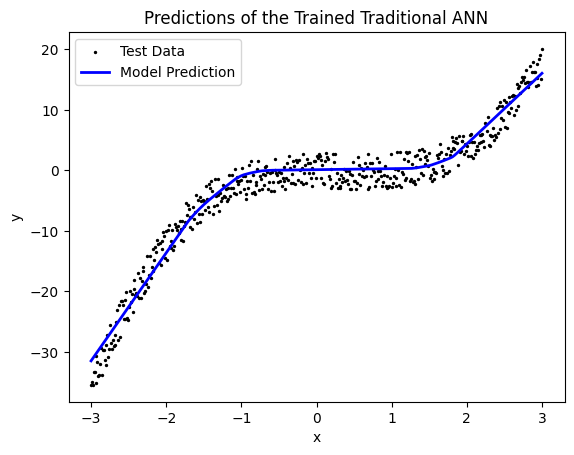

In [20]:
model.fit(x_train.numpy(), y_train.numpy(), epochs=30, batch_size=2, verbose=False)

#================================================
# Plotting the test data:
plt.scatter(x_test.data.numpy(), y_test.numpy(), color='k', s=2, label='Test Data') 

# Obtaining and plotting multiple predictions:
y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.numpy(), 'b-', linewidth=2, label='Model Prediction')

# Final formatting for the plot:
plt.title('Predictions of the Trained Traditional ANN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Storing the model weights to be used later...

In [21]:
model_weights = model.get_weights()

**IMPLEMENTATION NOTE: Why store the weights here and not call `model.get_weights` later?**

When within the HMC sampling loop, as per the implementation we are using, I experienced complications when trying to call `model.get_weights` in the function `evaluate_proposal` (defined above). Based on what I understood, `model.get_weights` relies on the use of Tensor-to-NumPy conversion, but it turns out that to do such a conversion within the sampling loop requires certain settings. In particular, I received the following error:

```
NotImplementedError: numpy() is only available when eager execution is enabled.
```

Maybe a possible solution is to enable eager execution within the model, using `model.run_eagerly = True`, but I prefer to assign the weights array beforehand and just use that array, for the sake of simplicity.

## Hamiltonian Monte Carlo (HMC) sampling

### Problem statement
Initially, the aim was to sample all the weights of the neural network together. However, due to two main complications in the implementation: (1) handling a non-homogenous list of weight arrays, which could not be passed as a single state to the HMC implementation I am using and is instead interpreted as multiple states, (2) the fact that the implementation of HMC I am using converts its states to symbolic tensors during sampling, which means that even if I convert my non-homogenous list of weight arrays into a single array, it is impossible to extract and reshape these weights once they are converted to symbolic tensors during sampling.

Hence, I decided to sample only the hidden weights, i.e. the weights connecting the two dense layers of the neural network. Thus, $\theta$ in this context does not refer to all the weights of the neural network, but only the weights between the two dense layers. Having trained the neural network using point-estimation, we shall take the other weights as constants and consider only the hidden weights as parameters to be distributed by the posterior. Hence, the goal is to sample and distribute the hidden weights, starting with the pre-trained model's weights.

In [37]:
layer = 1 # Indicating the hidden layer's weights

**NOTE**: _To see what layer of weights correspond to what part of the network, print out_ `model_weights` _and inspect it._

### Defining the prior
We define the prior as $P(\theta) = \text{MultivariateNormal}(0, I)$, where $I$ is the identity matrix.

---

_Why this choice of priors?_

For basic architectures such as Bayesian regression, a standard procedure is to use a normal prior with a zero mean 0 and a diagonal covariance $\sigma I$ on the coefficients of the network: $P(\theta) = \text{MultivariateNormal}(0, \sigma I)$. Although such an approach is often used in practice, there is no theoretical argument that makes it better than any other formulation. The normal prior is preferred due to its mathematical properties and the simple formulation of its logarithm, which is used in most of the learning algorithms.

> **Reference**: [Hands-on Bayesian Neural Networks – A Tutorial for Deep Learning Users](https://arxiv.org/pdf/2007.06823)

---

_Further points about the chosen prior_...

Choosing a multivariate normal prior with mean 0 and diagonal covariance $\sigma I$ is equivalent to a weighted $l_2$ regularization (with weights $\frac{1}{\sigma}$) when training a point estimate network. The documentation of the probabilistic programming language Stan (see here: [_Stan: A Probabilistic Programming Language_ from **Journal of Statistical Software**](https://www.jstatsoft.org/article/view/v076i01) provides examples on how to choose σ knowing the expected scale of the considered parameters (see here: [_Prior Choice Recommendations_ from `github.com`/`stan-dev`/`stan`/`wiki`](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)).

> **Reference**: [Hands-on Bayesian Neural Networks – A Tutorial for Deep Learning Users](https://arxiv.org/pdf/2007.06823)

---

Practical implementation...

In [22]:
def make_prior(dims, σ):
    return tfd.MultivariateNormalDiag(loc=tf.zeros([dims]), scale_diag=σ*tf.ones([dims]))

### Defining the likelihood

We assume the noise term $\epsilon$ in $y = f(x) + \epsilon$ is a random normal variable centered at 0 and with variance $\tau^2$:

$\epsilon \sim \text{Normal}(0, \tau^2)$

As a result, since $f$ is meant to be fixed once obtained, and since $x = (x_1, x_2 ... x_k)$ is a vector of covariates for which no distribution is considered, we have that the target variable $y$ is also distributed by a normal distribution; naturally, its variance is the same as the variance for the error term. More precisely, for every given vector of inputs and given parameterisation, the target value is normally distributed with mean $f(x) = \hat{y}$ and variance $\tau^2$:

$y \sim \text{Normal}(f(x), \tau^2)$

Hence, the likelihood _density_ of getting $y$ given input $x$ and parameterisation $\theta$ is given by:

$\text{Normal}(f(x), \tau^2)(y)$

$= \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y - f(x))^2}{2 \tau^2}}$ (probability density function of normal distribution)

$= \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y - \hat{y})^2}{2 \tau^2}}$ (since $\hat{y} = f(x)$)

**NOTE**: _We can only use density, because_ $y$ _is distributed across a continuous range, which means point-wise probability mass is always 0._

---

_Why are we using normally distributed noise?_ Even though our synthetic regression problem's noise term is uniformly distributed, we are assuming the noise term to be normally distributed due to certain mathematical and computational considerations, as shall be discussed later (after the definition of the log-likelihood function). The effect of considering the noise term to be normally distributed is that the typical set (i.e. the set of points that have the greatest contribution to the distribution estimation, i.e. the distribution's theoretical mean and variance) would be more concentrated around the mean, thus converging to the same mean as the uniformly distributed noise while having a lower variance.

---

Now, note that we estimate $f$ using a neural network (our model) with a particular parametrisation $\theta$. Let $f_\theta$ represent the neural network estimation of $f$ using the parametrisation $\theta$. Hence, more precisely (with respect to what we shall actually be computing), for every given vector of inputs and given parameterisation, the target value is normally distributed with mean $f_\theta(x) = \hat{y}$ and variance $\tau^2$:

$y \sim \text{Normal}(f_\theta(x), \tau^2) \implies \text{Normal}(f_\theta(x), \tau^2)(y) = \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y - \hat{y})^2}{2 \tau^2}}$, where $\hat{y} = f_\theta(x)$

---

In practice, we obtain a set of $n$ observed $y$ values, $D_y = (y_1, y_2 ... y_n)$, rather than a continuous range.

---

The likelihood _density_ of getting $D_y = (y_1, y_2 ... y_n)$ is given by:

$\displaystyle \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \tau^2}} e^{- \frac{(y_i - \hat{y_i})^2}{2 \tau^2}}$

The above product is computationally intensive; hence, in practice, we use the log-likelihood density.

---

**Deciding the likelihood distribution's variance** $\tau^2$:

There are two ways to approach this:

1. Assume or estimate a value for $\tau^2$
2. Include $\tau^2$ as a parameter to also be sampled and distributed by a posterior

In the following example, we shall try approach 1 (I will not use the sample variance of the target, for now, but play around with this value).

In [25]:
def make_likelihood(θ, model, x_data, τ_squared, layer):
    '''
    Calculate the likelihood of the data given the parameters
    ------------------------------------
    INPUT
    θ         : Vector of parameters
    τ_squared : Variance of the error term
    '''
    
    # First make a prediction with parameters θ:
    model_prediction = predict_for_proposal(model, x_data, θ, layer)
    # NOTE: = f_θ(x), i.e. output of the linear model parameterised by θ, without error

    # Return the likelihood distribution:
    return tfd.Normal(loc=model_prediction, scale=np.sqrt(τ_squared)*tf.ones_like(model_prediction))

**ADDITIONAL NOTE: Why use normally distributed noise instead of uniformly distributed noise?**

What if we considered the error term to be uniformly distributed, with mean 0 and range 6 (i.e. defined on $[-3, 3]$)?

$\epsilon \sim \text{Uniform}([-3, 3])$

As a result, since $f$ is meant to be fixed once obtained, and since $x = (x_1, x_2 ... x_k)$ is a vector of covariates for which no distribution is considered, then we have that the target variable $y$ is also distributed by a uniform distribution; naturally, the size of its range is the same as the size of the range for the error term. More precisely, for every given vector of inputs and given parameterisation, the target value is uniformly distributed on $[f(x) - 3, f(x) + 3]$:

$y \sim \text{Uniform}(f(x) - 3, f(x) + 3)$

---

Hence, the likelihood _density_ of getting $y$ given input $x$ and a model $f_\theta$ with parametrisation $\theta$ is given by:

$\text{Uniform}([f_\theta(x) - 3, f_\theta(x) + 3])(y) = 1_A(y) \cdot \frac{1}{6} = \frac{1_A(y)}{6}$, where:

- $A = [f_\theta(x) - 3, f_\theta(x) + 3]$
- $1_A$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) of $A$

**NOTE**: _Again, we can only use density, because_ $y$ _is distributed across a continuous range, which means point-wise probability mass is always 0._

---

Hence, the likelihood _density_ of getting $D_y = (y_1, y_2 ... y_n)$ is given by:

$\displaystyle \prod_{i=1}^n \frac{1_A(y_i)}{6}$

We cannot obtain the logarithm of the above likelihood, and thus, we cannot get the logarithm of the unnormalised posterior, which is needed as an argument to the implementation of HMC that we are using. Furthermore, since logarithms are much more numerically and computationally efficient, not being able to obtain combined log-probabilities would make computation more intensive or possibly infeasible for larger problems.

### Unnormalised log-probability of the posterior

In [38]:
def unnormalized_log_prob(θ):
    prior = make_prior(dims=θ.shape[0], σ=2)
    likelihood = make_likelihood(θ, model, x_train, τ_squared=4, layer=layer)
    p = prior.log_prob(θ) + tf.reduce_sum(likelihood.log_prob(y_train))
    return p

**IMPLEMENTATION NOTE: Shape mismatch during the calculation of Metropolis acceptance probability**:

It is crucial to ensure that the value returned by `unnormalized_log_prob` has no shape, i.e. it must be a pure scalar (not even having the shape as `(1,)`). Why? Because when the HMC implementation I am using calculates the Metropolis acceptance probability of the sample obtained after the specified number of leapfrog steps, it uses an operation `tf.add_n` on the output of `unnormalized_log_prob` and the state (i.e. $\theta$, the posterior sample). Now, note that `tf.add_n` relies on the first dimensions of the tensors passed to it to be equal; if one of the tensors is a pure scalar (i.e. has no dimension), only then is it broadcasted to the other tensor(s) without issue. In our case, the state is a vector and the output of `unnormalized_log_prob` is a scalar (since it is the unnormalised log-probability of the state). Thus, at most, even if we are not careful, the output of `unnormalized_log_prob` can have the shape `(1,)`, but we must be careful to make sure that as a tensor, it in fact has no dimension (i.e. its shape must be `()`) so that it is interpreted as a pure scalar.

#### Setting up the sampler

In [39]:
# Setup assumptions:
num_burnin_steps = 2500
num_results = 5000 # Number of samples to draw

# Defining an simple step size adaptation transition kernel (explained in the notes below):
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    # The HMC transition kernel is wrapped within the simple step size adaptation transition kernel:
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3, # Number of leapfrog steps from the initial position before proposing a sample
        step_size=1.0), # Size of each leapfrog step
    num_adaptation_steps=int(num_burnin_steps*0.8))

**CONCEPTUAL NOTE: Transition kernel (a.k.a. Markov kernel)**:

A transition kernel in this context refers to a Markov kernel and pertains to a given Markov chain (note that "Markov chain" = "Markov process"). A transition kernel of a Markov chain is a function that defines the transitions of the Markov chain. Specificallly, it defines the transition probabilities between states in the Markov chain (as a side note, it is a generalisation of the transition matrix in finite state Markov chains).

> **Reference**: [_Markov kernel_, **Wikipedia**](https://en.wikipedia.org/wiki/Markov_kernel)

---

**TECHNICAL NOTE: `tensorflow_probability.mcmc.TransitionKernel`**:

The base class for all MCMC transition kernels (defined above). This class defines the minimal requirements to efficiently implement a Markov chain Monte Carlo (MCMC) transition kernel. A transition kernel returns a new state given some old state (as a side note, it also takes and returns additional information which may be used for (a) debugging or (b) optimisation purposes, i.e, to "recycle" previously computed results).

> **Reference**: [`tfp.mcmc.TransitionKernel` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransitionKernel)

---

**IMPLEMENTATION NOTE: `tensorflow_probability.mcmc.SimpleStepSizeAdaptation`**:

It is a subclass of `tensorflow_probability.mcmc.TransitionKernel` that uses a simple policy to adapt the inner kernel's `step_size`, i.e. the size of each transition step from the current state to a proposal state), based on `log_accept_prob`, i.e. the logarithm of the Metropolis acceptance probability (note that logarithms are used since they are more numerically conservative and hence help avoid arithmetic overflow). More precisely, it multiplicatively increases or decreases the `step_size` of the inner kernel based on the value of `log_accept_prob`.

> **Reference**: [`tfp.mcmc.SimpleStepSizeAdaptation` (Tensorflow documentation)](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/SimpleStepSizeAdaptation)

---

**TECHNICAL NOTE: `tfp.mcmc.HamiltonianMonteCarlo`**:

`tfp.mcmc.HamiltonianMonteCarlo` is a subclass of `tensorflow_probability.mcmc.TransitionKernel`, just as HMC is a subclass of MCMC.

### Running the sampler

The sampling function...

In [40]:
# To enable quick execution:
tf.compat.v1.enable_eager_execution()
# NOTE: Eager execution is the default in `tensorflow`

# Run the chain (with burn-in):
@tf.function # This decorator is explained in the notes below
def run_chain(initial): # `initial` is the initial position of the sampler
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    # Returning the summary statistics of the samples as well as the samples themselves:
    return samples

**IMPLEMENTATION NOTE: `@tf.function` decorator**:

A tf.function that you define (for example by applying the @tf.function decorator) is just like a core TensorFlow operation: You can execute it eagerly; you can compute gradients; and so on.

> **Reference**: [Better performance with `tf.function` (Tensorflow documentation)](https://www.tensorflow.org/guide/function)

---

Run chain for pre-trained model...

In [41]:
initial = tf.constant(model_weights[layer]) # Initial position of the sampler
samples = run_chain(initial)

For reference, here is the shape of the obtained tensor of samples...

In [42]:
print(samples.shape)

(5000, 100)


Plotting the results of different parametrisations...

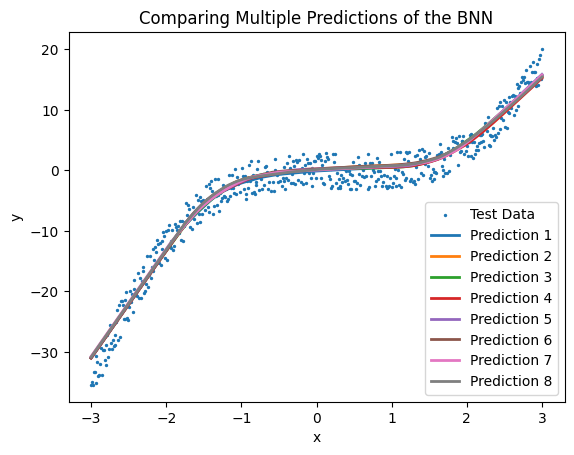

In [43]:
# Plotting the test data:
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), s=2, label='Test Data') 

# Obtaining and plotting multiple predictions:
for i in range(8):
    # Picking a random sample:
    random_sample = samples[np.random.choice(samples.shape[0])]
    # Prediction according to the parametrisation based on the above sample:
    y_predict = predict_for_proposal(model, x_test, random_sample, layer=layer)
    # Plotting the prediction:
    plt.plot(x_test.numpy(), y_predict.numpy(), linewidth=2, label=f'Prediction {i+1}')

# Final formatting for the plot:
plt.title('Comparing Multiple Predictions of the BNN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()